### パッケージのインポート

In [1]:
import os
import random
from datetime import datetime as dt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import STL

### データの確認

In [2]:
# ディレクトリ下に存在するファイル名の取得
def get_file_data(dir_path) -> list:
    filenames = sorted(os.listdir(dir_path))
    if ".DS_Store" in filenames:
        filenames.remove(".DS_Store")
    return filenames


# 欠損値数と最大値をとる時刻の確認
def null_max_cnt(filename_path, df_list):
    null_list = []
    max_list = []

    for i in range(len(df_list)):
        df = pd.read_csv(filename_path+df_list[i], index_col=0)
        null_list += [[df_list[i], df[["observed", "astoro", "deviation"]].isnull().any(axis=1).sum()]]
        max_list += [
            [df_list[i], df.loc[df["observed"].idxmax(), "datetime"]]
        ]

    return null_list, max_list

In [3]:
# 使用するリストの定義
filename_path = "../data/tsunami/NOWPHAS_Tsunami_data/csv/cut_csv/"
df_list = get_file_data(filename_path)
null_list, max_list = null_max_cnt(filename_path, df_list)

In [4]:
# 欠損値数を調べる
null_df = pd.DataFrame(null_list, columns=["filename", "null_num"])
null_df = null_df.sort_values(by=["null_num"], ascending=False)

null_df[null_df["null_num"] > 0]

,filename,null_num
7,cut_2011TET219W.csv,1095
6,cut_2011TET219T.csv,1017
3,cut_2011TET203W.csv,875
4,cut_2011TET205W.csv,834
2,cut_2011TET203T.csv,121
39,cut_2011TET812G.csv,7


In [5]:
# 各地点の水位が最大値をとる時刻を調べる
max_df = pd.DataFrame(max_list, columns=["filename", "datetime"])
max_df = max_df.sort_values(by="datetime")

max_df.head(10)

,filename,datetime
17,cut_2011TET319T.csv,2011-03-11 15:00:00
15,cut_2011TET317T.csv,2011-03-11 15:00:00
16,cut_2011TET318T.csv,2011-03-11 15:01:25
13,cut_2011TET315T.csv,2011-03-11 15:01:40
33,cut_2011TET802G.csv,2011-03-11 15:11:35
35,cut_2011TET804G.csv,2011-03-11 15:12:00
34,cut_2011TET803G.csv,2011-03-11 15:14:00
36,cut_2011TET806G.csv,2011-03-11 15:15:35
32,cut_2011TET801G.csv,2011-03-11 15:16:00
37,cut_2011TET807G.csv,2011-03-11 15:19:20


/var/folders/yy/h4ndzppd11l1g6sl_d1_jymw0000gq/T/ipykernel_63996/212569197.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


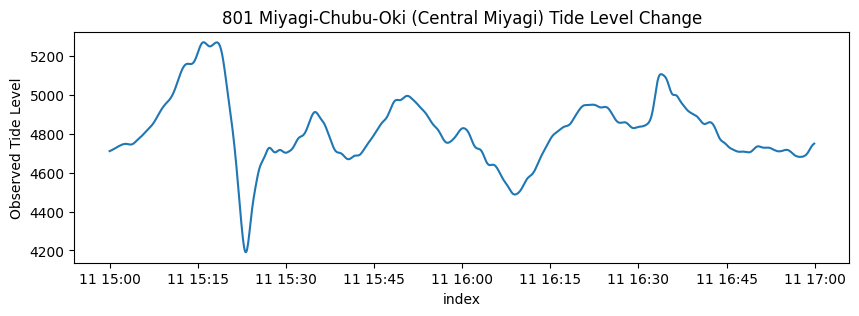

In [6]:
# 801Gの実測水位データの可視化
fig = plt.figure(figsize=(10,3))

cut_test_df = pd.read_csv(filename_path+"cut_2011TET801G.csv", index_col=0)
for i in range(len(cut_test_df)):
    s = cut_test_df.loc[i, "datetime"]
    cut_test_df.loc[i, "datetime"] = dt.strptime(s, "%Y-%m-%d %H:%M:%S")

plt.plot(cut_test_df["datetime"], cut_test_df["observed"])
plt.title("801 Miyagi-Chubu-Oki (Central Miyagi) Tide Level Change")
plt.xlabel("index")
plt.ylabel("Observed Tide Level")

fig.show()

#### 欠損値補完

In [7]:
# 欠損値補完
def completion(df:pd.DataFrame, nan_num, seed_val):
    random.seed(seed_val)
    nan_index = sorted(random.sample(range(1, len(df)-1), nan_num))

    nan_full_df = df.copy()
    for idx in nan_index:
        nan_full_df.loc[idx, "observed"] = float("nan")
    filled_df = nan_full_df.copy()

    for i in range(nan_num):
        if i != nan_num-1 and nan_index[i]+1 == nan_index[i+1]:
            filled_df.loc[nan_index[i], "observed"] = filled_df.loc[nan_index[i]-1, "observed"]
        else:
            filled_df.loc[nan_index[i], "observed"] = (filled_df.loc[nan_index[i]+1, "observed"]+
                                                    filled_df.loc[nan_index[i]-1, "observed"])/2

    return nan_full_df, filled_df, nan_index


# 補完したデータフレームを作成
def df_completion(pre_df: pd.DataFrame) -> pd.DataFrame:
    nan_index = []
    for i in range(len(pre_df)):
        if pre_df.loc[i].hasnans:
            nan_index.append(i)

    nan_full_df = pre_df.copy()
    for idx in nan_index:
        nan_full_df.loc[idx, "observed"] = float("nan")
    cmp_test_df = nan_full_df.copy()

    for i in range(len(nan_index)):
        if i == len(nan_index)-1 or nan_index[i]+1 == nan_index[i+1]:
            cmp_test_df.loc[nan_index[i], "observed"] = cmp_test_df.loc[nan_index[i]-1, "observed"]

        else:
            cmp_test_df.loc[nan_index[i], "observed"] = (cmp_test_df.loc[nan_index[i]+1, "observed"]+
                                                    cmp_test_df.loc[nan_index[i]-1, "observed"])/2

    # 合わせて潮位偏差も補完
    for i in range(len(cmp_test_df)):
        cmp_test_df.loc[i, "deviation"] = cmp_test_df.loc[i, "observed"] - cmp_test_df.loc[i, "astoro"]

    return cmp_test_df


In [8]:
# ランダムに発生させた欠損値に対して補完
full_df = cut_test_df.reset_index().drop("index", axis=1)
nan_test_df, completion_test_df, nan_index = completion(full_df, 3, seed_val=42)

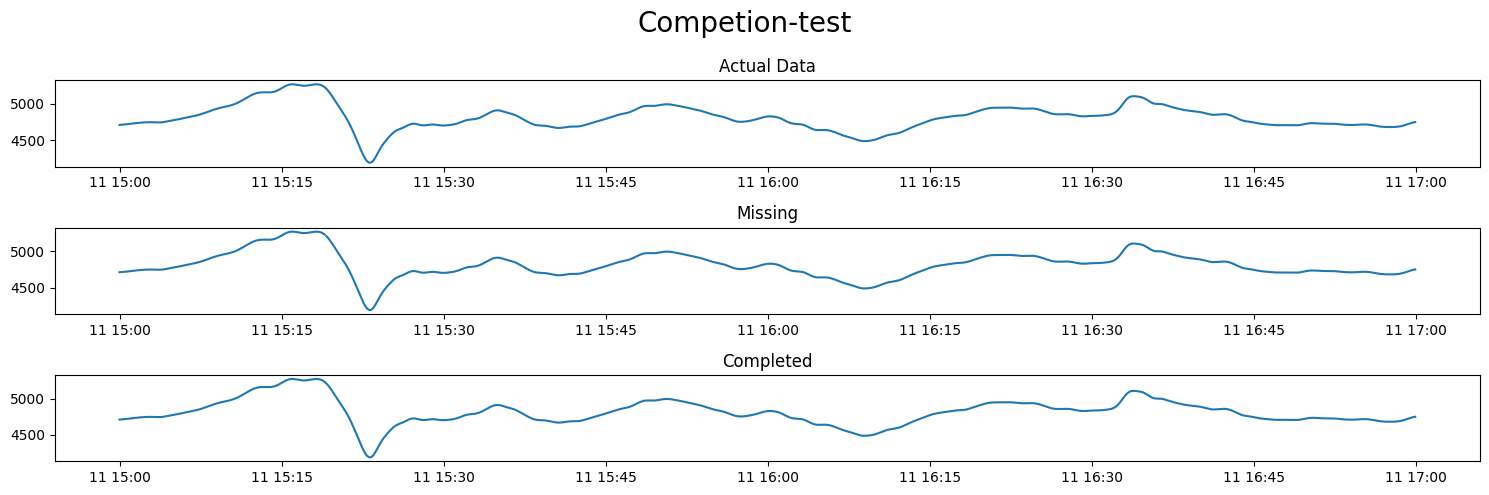

52      2011-03-11 15:04:20
229     2011-03-11 15:19:05
1310    2011-03-11 16:49:10
Name: datetime, dtype: object

In [9]:
# 補完前後のグラフを表示
fig, ax = plt.subplots(3,figsize=(15,5))

ax[0].plot(full_df["datetime"], full_df["observed"])
ax[0].set_title("Actual Data")

ax[1].plot(nan_test_df["datetime"], nan_test_df["observed"])
ax[1].set_title("Missing")

ax[2].plot(completion_test_df["datetime"], completion_test_df["observed"])
ax[2].set_title("Completed")

plt.suptitle("Competion-test", fontsize=20)
plt.tight_layout()
plt.show()

full_df.loc[nan_index, "datetime"]

In [10]:
# 補完方法の評価
num = 100
runs = 10**3

error = 0
for i in range(runs):
    nan_full_df, filled_df, nan_index = completion(full_df, num, seed_val=i)
    for idx in nan_index:
        error += abs(full_df.loc[idx, "observed"] - filled_df.loc[idx, "observed"])

# 平均絶対誤差に変換して出力
print(f"平均絶対誤差 :\n\terror : {error / (num * runs)}")

平均絶対誤差 :
	error : 0.54435149999998


誤差は小さなものであるから,この方法を用いて,各データに対し補完を行う.

In [11]:
# 全水位データを補完データで置き換える
cmp_filename_path = "../data/tsunami/NOWPHAS_Tsunami_data/csv/cmp_csv/"

for file in df_list:
    df = pd.read_csv(filename_path+file, index_col=0)
    df = df_completion(df)
    df.to_csv(cmp_filename_path+file)

### データフレームの作成

In [12]:
# メインデータフレームの作成
main_df = cut_test_df
main_df = main_df.drop(["index", "deviation", "datetime"], axis=1)

# 過去の水位データの連結
main_df_times = [f"observed_{5*i}s" for i in range(1, 13)]
for i in range(len(main_df_times)):
    main_df[main_df_times[i]] = main_df["observed"].shift(i+1)
    main_df[main_df_times[i]] = main_df["observed"] - main_df[main_df_times[i]]

In [13]:
# 801Gより先に津波が到達する地点の水位データを結合
cmp_filenames = ["2011TET318T.csv", "2011TET317T.csv",
                 "2011TET315T.csv", "2011TET319T.csv",
                 "2011TET802G.csv", "2011TET804G.csv",
                 "2011TET803G.csv", "2011TET806G.csv"]

pre_list = []
pre_columns = []

for filename in cmp_filenames:
    pre_df = pd.read_csv(filename_path+"cut_"+filename, index_col=0)
    pre_list.append(pre_df["observed"])
    pre_columns.append(f"observed+{filename[7:11]}")

for i in range(len(pre_columns)):
    main_df[pre_columns[i]] = pre_list[i]

# 欠損値を含むデータの削除
main_df = main_df.copy().dropna()
main_df = main_df.reset_index().drop("index", axis=1)

main_df

,observed,astoro,observed_5s,observed_10s,observed_15s,observed_20s,observed_25s,observed_30s,observed_35s,observed_40s,...,observed_55s,observed_60s,observed+318T,observed+317T,observed+315T,observed+319T,observed+802G,observed+804G,observed+803G,observed+806G
0,4726.83,4690.90,1.52,3.06,4.41,5.95,7.09,8.62,9.61,10.94,...,14.44,15.49,95.16,67.79,66.62,93.19,52.70,4387.20,4680.90,4495.50
1,4728.27,4690.92,1.44,2.96,4.50,5.85,7.39,8.53,10.06,11.05,...,14.56,15.88,95.31,67.76,66.79,93.16,55.87,4388.60,4682.60,4496.60
2,4729.88,4690.94,1.61,3.05,4.57,6.11,7.46,9.00,10.14,11.67,...,15.25,16.17,95.43,67.71,67.01,93.11,58.98,4390.10,4684.50,4497.70
3,4731.36,4690.95,1.48,3.09,4.53,6.05,7.59,8.94,10.48,11.62,...,15.47,16.73,95.52,67.62,67.23,93.03,62.28,4391.60,4686.50,4498.80
4,4732.83,4690.97,1.47,2.95,4.56,6.00,7.52,9.06,10.41,11.95,...,15.61,16.94,95.57,67.51,67.45,92.93,65.51,4393.10,4688.60,4499.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1423,4740.25,4721.28,3.47,7.32,11.34,15.88,20.07,24.60,29.00,33.30,...,43.73,46.40,5.98,-54.70,-3.58,6.30,140.82,4522.30,4793.83,4497.84
1424,4743.13,4721.30,2.88,6.35,10.20,14.22,18.76,22.95,27.48,31.88,...,43.46,46.61,5.87,-54.80,-3.82,6.16,139.59,4522.90,4791.94,4498.49
1425,4745.78,4721.32,2.65,5.53,9.00,12.85,16.87,21.41,25.60,30.13,...,42.94,46.11,5.72,-54.90,-4.04,6.03,138.22,4523.70,4790.54,4499.17
1426,4747.96,4721.34,2.18,4.83,7.71,11.18,15.03,19.05,23.59,27.78,...,41.01,45.12,5.56,-54.98,-4.25,5.91,136.83,4524.39,4789.07,4499.60


### 重回帰分析

In [14]:
# 重回帰分析を行う
def train_predict(X, y, split_rate):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_rate, random_state=316)
    regressor = LinearRegression().fit(X_train, y_train)
    
    y_train_pred = regressor.predict(X_train)
    y_pred = regressor.predict(X_test)
    for i in range(len(y_pred)):
        y_pred[i] = round(y_pred[i])
    
    train_mse = np.mean((y_train_pred - y_train) ** 2)
    test_mse = np.mean((y_pred - y_test) ** 2)
    print("MSE train data: ", train_mse)
    print("MSE test data: ", test_mse)

    out = {
        "X_train": X_train,
        "y_train": y_train,
        "X_test": X_test,
        "y_test": y_test,
        "y_pred": y_pred,
        "y_train_pred": y_train_pred
    }

    return regressor, out

In [15]:
# 重回帰分析を実行
X = main_df.drop("observed", axis=1)
y = main_df["observed"]
regressor, out = train_predict(X, y, 0.30)

# 決定係数の算出
print("r^2 train data: ", r2_score(out["y_train"], out["y_train_pred"]))
print("r^2 test data: ", r2_score(out["y_test"], out["y_pred"]))

MSE train data:  16167.494539814803
MSE test data:  18217.75118088578
r^2 train data:  0.4797045563436174
r^2 test data:  0.40278612860070684


学習データ,テストデータともに誤差が大きく,決定係数も小さいことから,モデルの精度は良くないと言える.

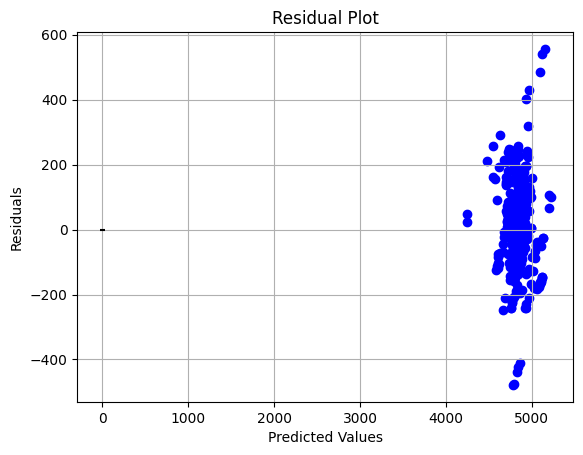

In [16]:
# 残差プロット
plt.scatter(out["y_pred"], out["y_pred"] - out["y_test"], color = "blue")
plt.hlines(y = 0, xmin = -30, xmax = 30, color="black")
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid()

plt.show()

### 主成分分析による次元圧縮

In [17]:
# 平均二乗誤差を用いた最適パラメータの算出
def best_parameter(max_n):
    score_list = []
    n_list = np.arange(1, max_n)
    for n in n_list:
        cv = KFold(n_splits=5, random_state=0, shuffle=True)
        model = Pipeline([
            ("scale", StandardScaler()),
            ("decomposition", PCA(n_components=n)),
            ("model", LinearRegression())
        ])
        scores = cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=cv, n_jobs=-1)
        score_list.append(-np.mean(scores))
    return n_list[np.argmin(score_list)]


# パイプラインの実行結果を表示
def pipeline_result(pipeline, X_train, y_train, X_test, y_test):
    # 平均二乗誤差の算出
    train_mse = np.mean((pipeline.predict(X_train) - y_train) ** 2)
    test_mse = np.mean((pipeline.predict(X_test) - y_test) ** 2)
    print("MSE train data: ", train_mse)
    print("MSE test data: ", test_mse)
    print("\n")

    # 決定係数の算出
    print("r^2 train data: ", r2_score(y_train, pipeline.predict(X_train)))
    print("r^2 test data: ", r2_score(y_test, pipeline.predict(X_test)))

In [18]:
# 最適パラメータの算出
best_n_components = best_parameter(22)
print(f"best_n_components: {best_n_components}")

# 標準化および次元圧縮、重回帰分析を行う
pca_pipeline = Pipeline([
    ("scale", StandardScaler()),
    ("decomposition", PCA(n_components=best_n_components)),
    ("model", LinearRegression())
])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=316)
pca_pipeline.fit(X_train, y_train)

pipeline_result(pca_pipeline, X_train, y_train, X_test, y_test)

best_n_components: 18
MSE train data:  16203.75642579154
MSE test data:  18241.826956215806


r^2 train data:  0.4785375917279423
r^2 test data:  0.40199687712564725


18次元に圧縮したものの, 良い精度は得られなかった.

### ノンパラメトリック回帰

#### 季節成分の確認

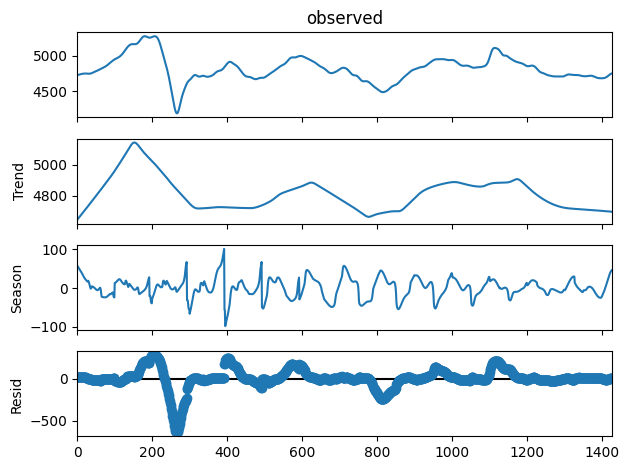

In [19]:
# STL分解
stl = STL(main_df.observed, period=100, robust=True).fit()
stl.plot()
plt.show()

グラフから,季節成分が存在することがわかる.また,これは波の周期によるものであると予想できる.

#### ノンパラメトリック回帰の実行

In [20]:
# 平均二乗誤差を用いた最適パラメータの算出
def best_parameter_2(max_k):
    score_list = []
    k_list = np.arange(1, max_k)

    for k in k_list:
        cv = KFold(n_splits=5, random_state=0, shuffle=True)
        knn_model = Pipeline([
        ("scale", StandardScaler()),
        ("decomposition", PCA(n_components=18)),
        ("model", KNeighborsRegressor(n_neighbors=k))
        ])

        scores = cross_val_score(knn_model, X, y, scoring="neg_mean_squared_error", cv=cv, n_jobs=-1)
        score_list.append(-np.mean(scores))
    return k_list[np.argmin(score_list)]

In [21]:
# 最適パラメータの算出
best_n_neighbors = best_parameter_2(30)
print(f"best_n_neighbors: {best_n_neighbors}")

# 標準化および次元圧縮、kNN回帰分析を行う
knn_pipeline = Pipeline([
    ("scale", StandardScaler()),
    ("decomposition", PCA(n_components=18)),
    ("model", KNeighborsRegressor(n_neighbors=best_n_neighbors))
])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=316)
knn_pipeline.fit(X_train, y_train)

pipeline_result(knn_pipeline, X_train, y_train, X_test, y_test)

best_n_neighbors: 2
MSE train data:  19.329816491491425
MSE test data:  45.73503135198124


r^2 train data:  0.9993779360541938
r^2 test data:  0.9985007153264371


先ほどの重回帰分析の場合と比較すると,かなり精度が改善されたことがわかる.

#### 可視化による比較

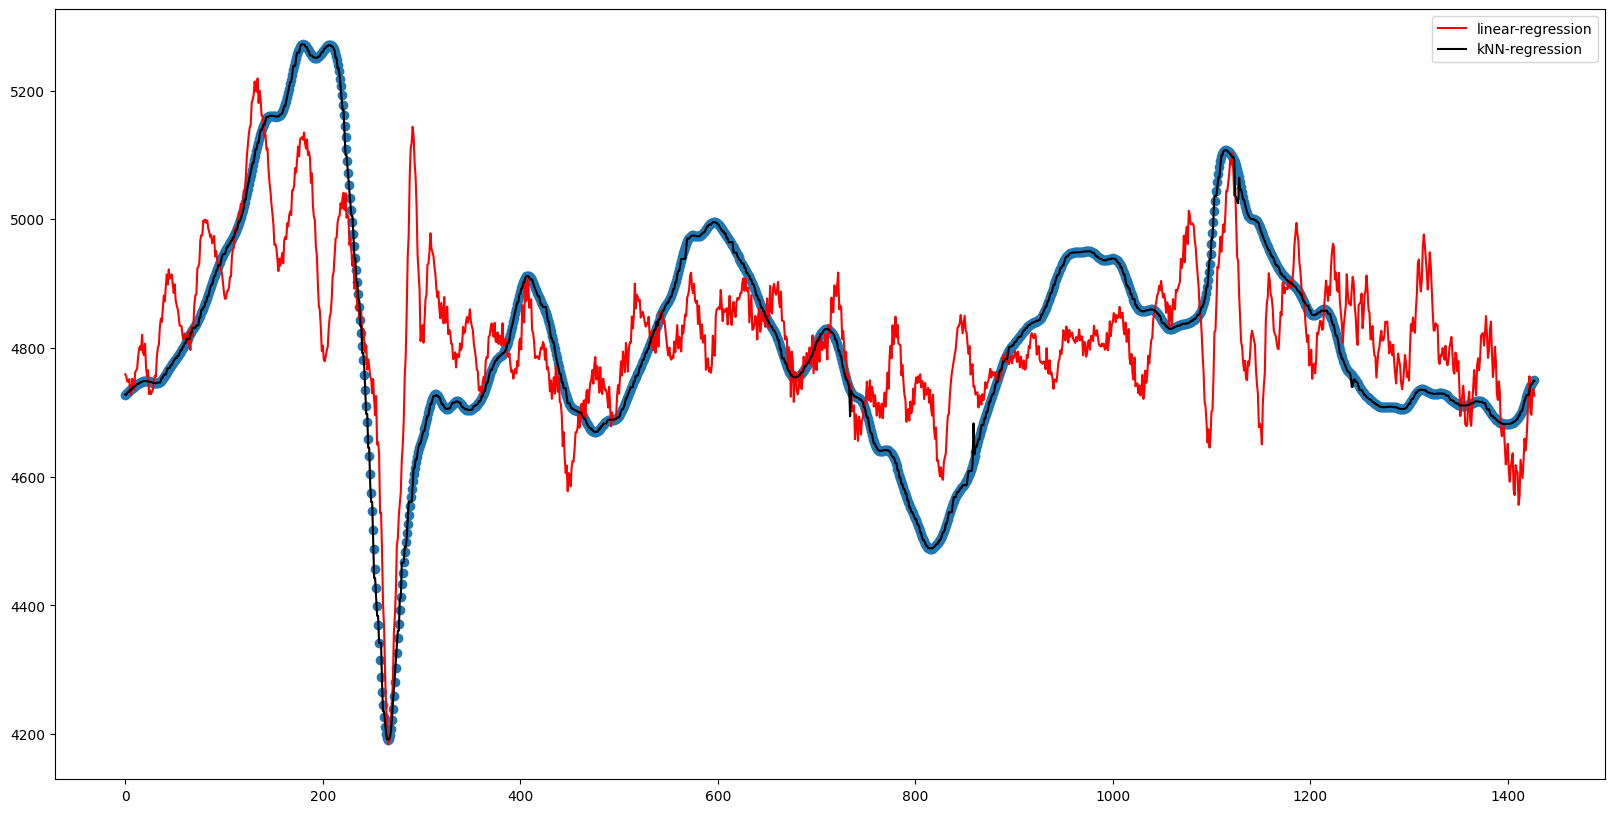

In [22]:
fig = plt.figure(figsize=(20,10))

plt.scatter(X.index, y)
plt.plot(X.index, pca_pipeline.predict(X), color="red", label="linear-regression")
plt.plot(X.index, knn_pipeline.predict(X), color="black", label="kNN-regression")

plt.legend()
plt.show()